# ***Cross-Validation***

## ***Universidad Central***

## ***Maestría en analítica de datos***

## ***Métodos estadísticos para analítica de datos.***
## ***Docente: Luis Andrés Campos Maldonado.***

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
    cross_validate
)

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos-Estadisticos/main/data/"

## ***Cross-Validation.***

Pensemos en la siguiente situación de la vida "real":

_Usted está estudiando para un examen y ha logrado memorizar muchos de los ejercicios que ha desarrollado como preparación, dado que usted "memorizó" (no-generalizó) seguramente en un exámen con las mismas preguntas (que usted ya "memorizó") tendrá un buen resultado. Siguiendo en la analogía, ¿cómo cree que será su calificación si el exámen tiene un grupo de preguntas que usted nunca ha estudiado? Recuerde que solo "memorizó"..._



Suponga ahora que está construyendo un modelo de `machine learning`, ¿cómo puede eliminar el problema  de "memorizar" del sistema? Intuitivamente, parece completamente lógico dejar un conjunto de datos reservados (`set_test`) que NO hará parte del entrenamiento del modelo y luego de entrenado dicho modelo aplicarlo sobre los datos reservados para ver que tan bien se comporta. En este caso, usaría la mayoría de los datos para ajustar el modelo (entrenar) y usar una porción más pequeña para probar el modelo. ¿Qué tan diferente sería la evaluación si selecciona una muestra reservada diferente?


La técnica de _**[cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)**_ amplía la idea de una muestra reservada a múltiples muestras reservas secuenciales. 

1. Reserve $1/k$ de los datos como muestra reservada.

2. Entrene el modelo con los datos restantes.

3. Aplique (score) el modelo a la reserva de $1/k$ y registre la métrica(s) de evaluación del modelo que desea.

4. Restaure el primer $1/k$ de los datos y reserve el siguiente $1/k$ (excluyendo cualquier registro que fue elegido la primera vez).

5. Repita los pasos 2 y 3.

6. Repita hasta que se haya utilizado cada registro en la parte reservada.

7. Promediar o combinar las métricas de evaluación del modelo.

La división de los datos en la muestra de entrenamiento y la muestra reservada también se denomina
un ***fold.***

Para hacer uso de esta técnica podemos usar las siguientes herramientas:

1. [`sklearn.model_selection.StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

2. [`sklearn.model_selection.KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

3. [`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)

In [2]:
# Preparamos la Data
df_to_model = pd.read_parquet(url_base + "Logistic_Regression_1.parquet",)
df_to_model.drop_duplicates(inplace=True)
df_to_model["tasa_de_interes"] = df_to_model["tasa_de_interes"].str.replace("%", "").astype("float")
df_to_model.drop(columns=["estado_de_verificacion"], inplace=True)
df_to_model

,estado_del_prestamo,ingreso_anual,anios_de_experiencia_laboral,tenencia_de_vivienda,tasa_de_interes,monto_del_prestamo,proposito,plazo,calificacion
0,completamente_pagado,24000.0,10+ años,alquiler,10.65,5000,tarjeta_de_credito,36 meses,B
1,dado_de_baja,30000.0,< 1 año,alquiler,15.27,2500,auto,60 meses,C
2,completamente_pagado,12252.0,10+ años,alquiler,15.96,2400,pequeno_negocio,36 meses,C
3,completamente_pagado,49200.0,10+ años,alquiler,13.49,10000,otro,36 meses,C
4,completamente_pagado,80000.0,1 año,alquiler,12.69,3000,otro,60 meses,B
...,...,...,...,...,...,...,...,...,...
38700,completamente_pagado,110000.0,4 años,hipoteca,8.07,2500,remodelacion_del_hogar,36 meses,A
38701,completamente_pagado,18000.0,3 años,alquiler,10.28,8500,tarjeta_de_credito,36 meses,C
38702,completamente_pagado,100000.0,< 1 año,hipoteca,8.07,5000,consolidacion_de_deudas,36 meses,A
38703,completamente_pagado,200000.0,< 1 año,hipoteca,7.43,5000,otro,36 meses,A


In [3]:
categorical_features = [col for col in df_to_model.select_dtypes(exclude=np.number).columns if col != "estado_del_prestamo"]
numeric_features = [col for col in df_to_model.columns if col not in categorical_features and col != "estado_del_prestamo"]

preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(drop="first"), categorical_features),
        ("num", "passthrough", numeric_features)        
    ]
)

X = df_to_model[categorical_features + numeric_features]
X = preprocessor.fit_transform(X)
y = label_binarize(df_to_model["estado_del_prestamo"], classes=["dado_de_baja", "completamente_pagado"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

## ***Modelo Logistic Regression.***

In [4]:
# Logistic Regression con sklearn.
model_lr = LogisticRegression(C=1e10, solver="newton-cg", fit_intercept=True, random_state=123)
model_lr.fit(X_train,y_train)

predict_proba_train = model_lr.predict_proba(X_train)[:,1]
predict_proba_test = model_lr.predict_proba(X_test)[:,1]

print(f"Logistic Regression AUC Train = {roc_auc_score(y_train, predict_proba_train):.3f}")
print(f"Logistic Regression AUC Test = {roc_auc_score(y_test, predict_proba_test):.3f}")

Logistic Regression AUC Train = 0.692
Logistic Regression AUC Test = 0.688


In [5]:
cv_results_lr = cross_validate(
    model_lr,
    X_train,
    y_train,
    cv=5,
    scoring=("roc_auc","f1"),
    return_train_score=True,
)

pd.DataFrame(cv_results_lr)

,fit_time,score_time,test_roc_auc,train_roc_auc,test_f1,train_f1
0,2.472225,0.010654,0.695260,0.690147,0.924080,0.924381
1,2.239501,0.010728,0.669770,0.696917,0.923786,0.924422
2,2.684600,0.005953,0.705949,0.687860,0.924389,0.924411
3,1.066561,0.005805,0.685432,0.692836,0.924441,0.924251
4,1.169047,0.004714,0.680731,0.694208,0.924509,0.924325


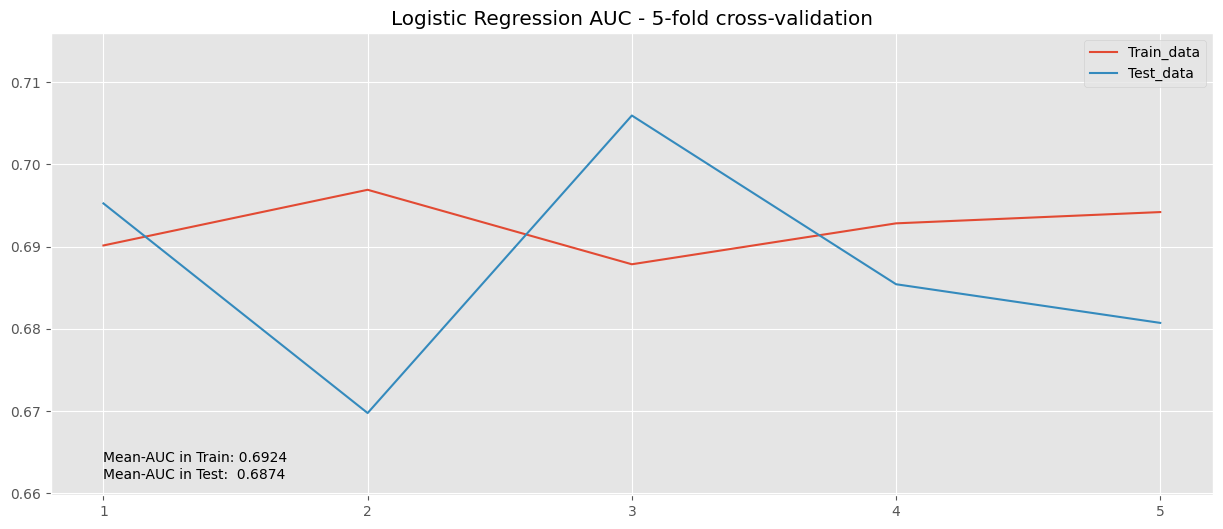

In [6]:
train_lr, test_lr = cv_results_lr["train_roc_auc"], cv_results_lr["test_roc_auc"]
means_lr = (train_lr.mean(), test_lr.mean())
# Para los límites en el eje y
values_aucs_lr = np.concatenate((train_lr, test_lr), axis=None)
min_y, max_y = values_aucs_lr.min() -0.01 , values_aucs_lr.max()+ 0.01
##
plt.plot(cv_results_lr["train_roc_auc"], label="Train_data")
plt.plot(cv_results_lr["test_roc_auc"], label = "Test_data")
plt.title("Logistic Regression AUC - 5-fold cross-validation")
plt.legend()
plt.text(0, min_y + 4e-03, f"Mean-AUC in Train: {means_lr[0]:.4f}")
plt.text(0, min_y + 2e-03, f"Mean-AUC in Test:  {means_lr[1]:.4f}")
plt.ylim(min_y, max_y)
plt.xticks(np.arange(0,5), np.arange(1,6))
plt.show()

## ***Modelo Random Forrest.***

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(), categorical_features),
        ("num", "passthrough", numeric_features)        
    ]
)

X = df_to_model[categorical_features + numeric_features]
X = preprocessor.fit_transform(X)
y = label_binarize(df_to_model["estado_del_prestamo"], classes=["dado_de_baja", "completamente_pagado"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

model_rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=123)
model_rf.fit(X_train,y_train)

predict_proba_train = model_rf.predict_proba(X_train)[:,1]
predict_proba_test = model_rf.predict_proba(X_test)[:,1]

print(f"Random Forrest AUC Train = {roc_auc_score(y_train, predict_proba_train):.3f}")
print(f"Random Forrest AUC Test = {roc_auc_score(y_test, predict_proba_test):.3f}")

Random Forrest AUC Train = 0.683
Random Forrest AUC Test = 0.685


In [8]:
# cross_validate en RandomForrest.
cv_results_rf = cross_validate(
    model_rf,
    X_train,
    y_train,
    cv=5,
    scoring=("roc_auc","f1"),
    return_train_score=True,
    verbose=3
)

[CV] END  f1: (train=0.924, test=0.924) roc_auc: (train=0.685, test=0.677) total time=   1.2s
[CV] END  f1: (train=0.924, test=0.924) roc_auc: (train=0.689, test=0.661) total time=   1.1s
[CV] END  f1: (train=0.924, test=0.924) roc_auc: (train=0.682, test=0.694) total time=   0.9s
[CV] END  f1: (train=0.924, test=0.924) roc_auc: (train=0.684, test=0.681) total time=   0.7s
[CV] END  f1: (train=0.924, test=0.924) roc_auc: (train=0.685, test=0.681) total time=   0.7s


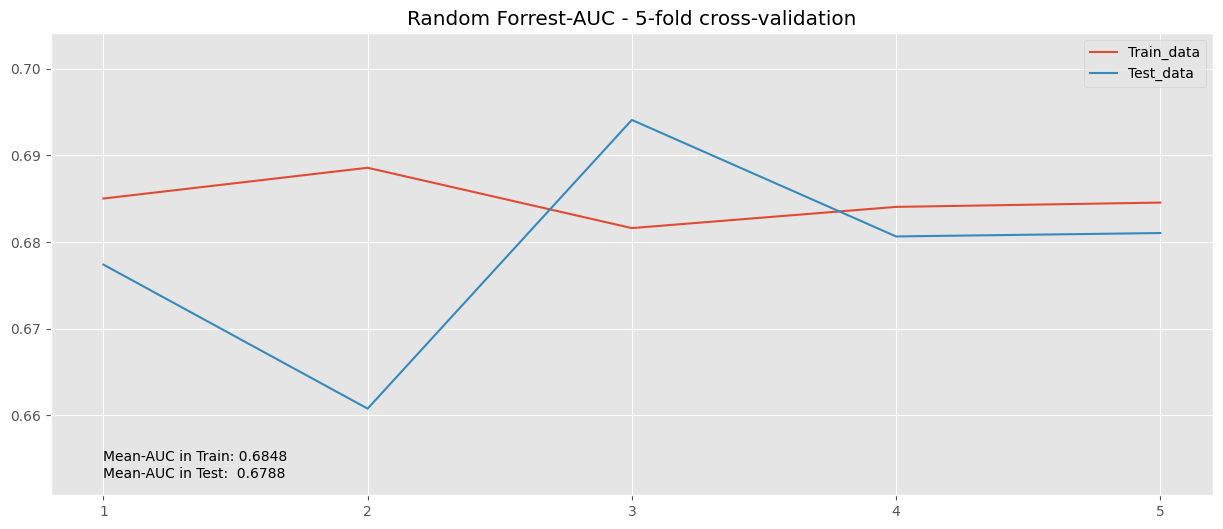

In [ ]:
train_lr, test_lr = cv_results_rf["train_roc_auc"], cv_results_rf["test_roc_auc"]

values_aucs_lr = np.concatenate((train_lr, test_lr), axis=None)
min_y, max_y = values_aucs_lr.min() -0.01 , values_aucs_lr.max()+ 0.01
means_rf = (train_lr.mean(), test_lr.mean())

plt.plot(cv_results_rf["train_roc_auc"], label = "Train_data")
plt.plot(cv_results_rf["test_roc_auc"], label = "Test_data")
plt.title("Random Forrest-AUC - 5-fold cross-validation")
plt.legend()
plt.text(0, min_y + 4e-03, f"Mean-AUC in Train: {means_rf[0]:.4f}")
plt.text(0, min_y + 2e-03, f"Mean-AUC in Test:  {means_rf[1]:.4f}")
plt.ylim(min_y, max_y)
plt.xticks(np.arange(0,5),np.arange(1,6))
plt.show()

## ***Búsqueda de parámetros.***

Vamos a hacer uso de: [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [10]:
# 1 minuto 30 segundos aprox. corriendo.
rf_model = RandomForestClassifier()
params = {
    "n_estimators": [50, 75, 100, 150, 200], 
    "max_depth": [3, 4, 5], 
    "criterion": ["gini", "entropy"],
    "min_samples_split" : [150, 200, 300]
}

clf_rf = GridSearchCV(
    rf_model, 
    params, 
    scoring="roc_auc", 
    cv=3, 
    n_jobs=-1,
    return_train_score=True
)

best_model_grid = clf_rf.fit(X_train,  y_train.ravel())
print("Mejores parametros:\n")
print(best_model_grid.best_params_)

print(f'Random Forrest AUC (Train)= {roc_auc_score(y_train, best_model_grid.predict_proba(X_train)[:,1]):.4f}')
print(f'Random Forrest AUC (Test)= {roc_auc_score(y_test, best_model_grid.predict_proba(X_test)[:,1]):.4f}')

Mejores parametros:

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 150, 'n_estimators': 75}
Random Forrest AUC (Train)= 0.6939
Random Forrest AUC (Test)= 0.6899


Merojes parametros GridSearchCV:

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 150,
 'n_estimators': 75}


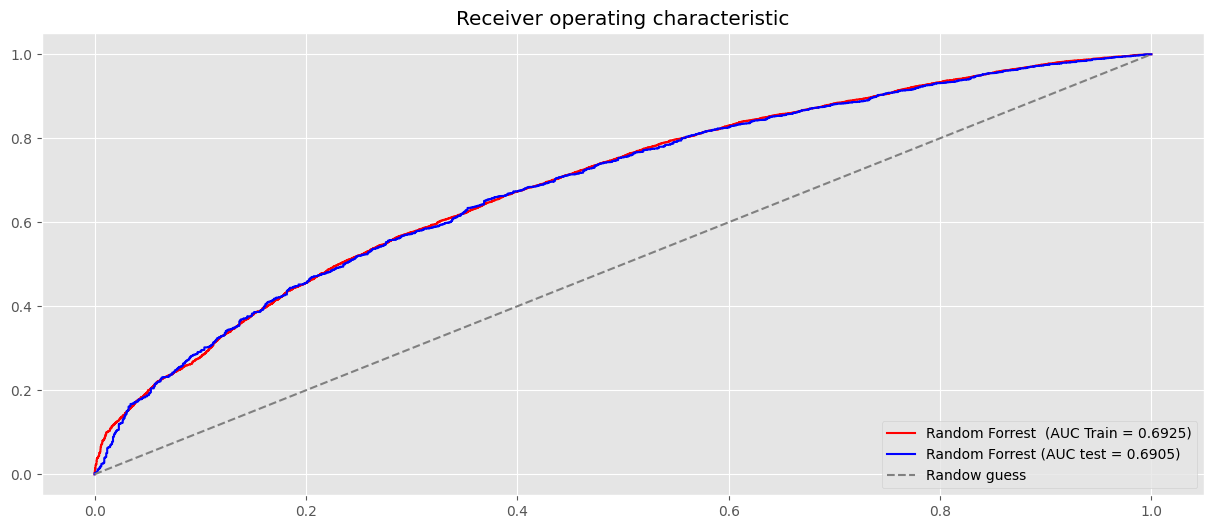

In [11]:
print("Merojes parametros GridSearchCV:\n")
pprint(clf_rf.best_params_)
clf_best = clf_rf.best_estimator_.fit(X_train,y_train)

# Curva de ROC en el set de Train.
probas_train = clf_best.predict_proba(X_train)[:,1]
fpr, tpr, _ = roc_curve(y_train, probas_train)
plt.plot(fpr, tpr, label=f"Random Forrest  (AUC Train = {auc(fpr, tpr):.4f})", color="r")

# Curva de ROC en el set de test.
probas_test = clf_best.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, probas_test)
plt.plot(fpr_test, tpr_test, label=f"Random Forrest (AUC test = {auc(fpr_test, tpr_test):.4f})", color="b")

plt.plot((0,1), (0,1), ls = "--", color = "grey", label = "Randow guess")
plt.legend(loc="lower right")
plt.title("Receiver operating characteristic")
plt.show()

Vamos a hacer uso de: [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In [12]:
rf_model = RandomForestClassifier()

params = {
    "max_depth": [n for n in range(2, 15)], 
    "criterion": ["gini", "entropy", "log_loss"], 
    "min_samples_split" : [100 + 10*n for n in range(0, 28, 5)],
    "n_estimators":[100 + n for n in range(5, 101, 2)]
}

clf_rf2 = RandomizedSearchCV(
    rf_model,
    params,
    random_state=0,
    scoring="roc_auc",
    cv=5,
    n_iter=10,
    n_jobs=-1,
    return_train_score=True
)

best_model_random = clf_rf2.fit(X_train, y_train.ravel())
print(best_model_random.best_params_)

print(f'Random Forrest AUC (Train)= {roc_auc_score(y_train, best_model_random.predict_proba(X_train)[:,1]):.4f}')
print(f'Random Forrest AUC (Test)= {roc_auc_score(y_test, best_model_random.predict_proba(X_test)[:,1]):.4f}')

{'n_estimators': 153, 'min_samples_split': 200, 'max_depth': 12, 'criterion': 'entropy'}
Random Forrest AUC (Train)= 0.7343
Random Forrest AUC (Test)= 0.6934


In [13]:
X = df_to_model[categorical_features + numeric_features]
y = label_binarize(df_to_model["estado_del_prestamo"], classes=["dado_de_baja", "completamente_pagado"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(), categorical_features),
        ("num", "passthrough", numeric_features)        
    ]
)

clf_pipeline_full = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier())
])

params = {    
    "classifier__max_depth": [2, 3, 4, 5, 6],
    "classifier__criterion": ["gini", "entropy", "log_loss"],
    "classifier__min_samples_split": [300 + 50 * n for n in range(0, 28)],
    "classifier__n_estimators": [50 + n for n in range(10, 201, 10)],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [2, 3, 4, 6, 8]
}

clf = RandomizedSearchCV(
    clf_pipeline_full,
    params,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    random_state=0,
    return_train_score=True
)

search = clf.fit(X_train, y_train.ravel())

Merojes parametros RandomizedSearchCV:

{'classifier__criterion': 'log_loss',
 'classifier__max_depth': 6,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 6,
 'classifier__min_samples_split': 550,
 'classifier__n_estimators': 120}


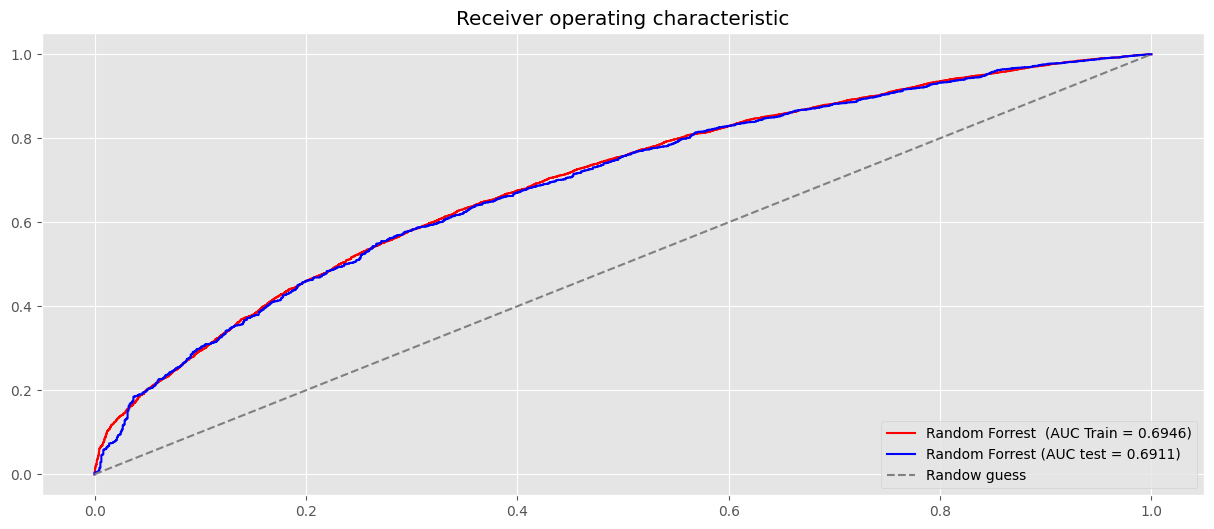

In [14]:
print("Merojes parametros RandomizedSearchCV:\n")
pprint(search.best_params_)
clf_best = search.best_estimator_.fit(X_train,y_train)

# Curva de ROC en el set de Train.
probas_train = clf_best.predict_proba(X_train)[:,1]
fpr, tpr, _ = roc_curve(y_train, probas_train)
plt.plot(fpr, tpr, label=f"Random Forrest  (AUC Train = {auc(fpr, tpr):.4f})", color="r")

# Curva de ROC en el set de test.
probas_test = clf_best.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, probas_test)
plt.plot(fpr_test, tpr_test, label=f"Random Forrest (AUC test = {auc(fpr_test, tpr_test):.4f})", color="b")

plt.plot((0,1), (0,1), ls = "--", color = "grey", label = "Randow guess")
plt.legend(loc="lower right")
plt.title("Receiver operating characteristic")
plt.show()

In [15]:
pd.DataFrame(search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_features,param_classifier__max_depth,param_classifier__criterion,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.913645,0.099537,0.263868,0.029496,140,1550,3,sqrt,4,log_loss,...,0.689639,0.680822,0.680533,0.007556,15,0.688090,0.682878,0.691095,0.687354,0.003395
1,4.021640,0.226971,0.280566,0.010007,130,1400,4,log2,4,entropy,...,0.690288,0.681141,0.680666,0.008057,14,0.688579,0.682976,0.689534,0.687030,0.002893
2,5.230767,0.750617,0.343619,0.061646,190,400,3,log2,4,entropy,...,0.688869,0.679917,0.680300,0.006845,17,0.691832,0.683030,0.691094,0.688652,0.003986
3,5.960938,0.539384,0.346234,0.057898,170,1600,3,sqrt,5,entropy,...,0.692305,0.680951,0.681794,0.008259,8,0.691028,0.685936,0.691477,0.689480,0.002513
4,2.543609,0.260430,0.197143,0.007216,90,1600,4,log2,5,gini,...,0.690800,0.680738,0.681201,0.007656,12,0.689573,0.684772,0.689843,0.688063,0.002330


Best hyperparameters RandomizedSearchCV:

{'classifier__class_weight': None,
 'classifier__max_depth': 6,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 8,
 'classifier__min_samples_split': 200,
 'classifier__n_estimators': 300}


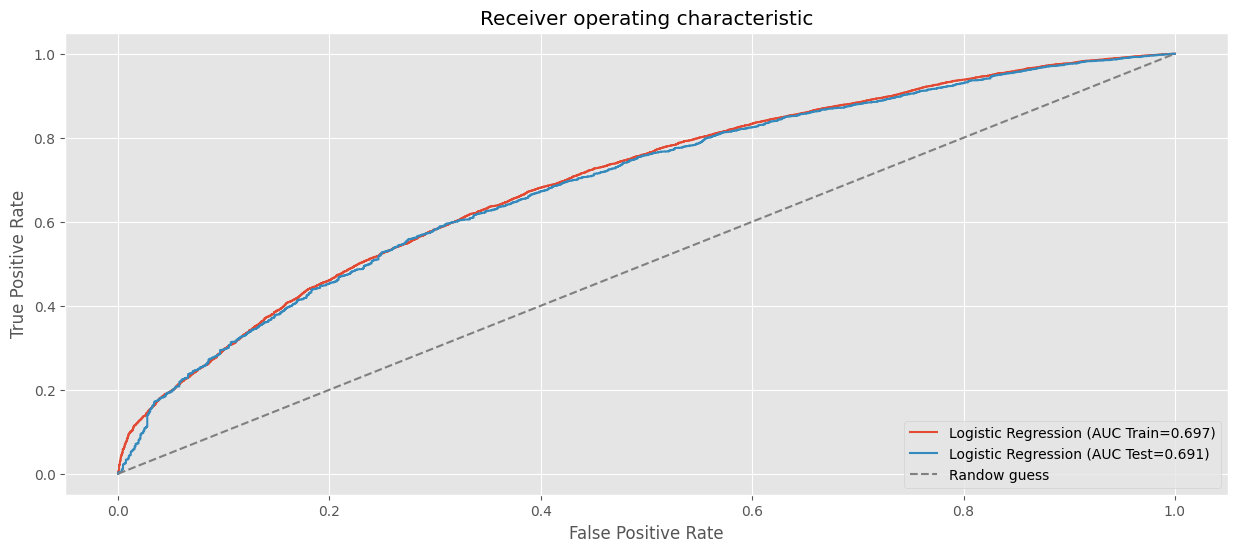

In [ ]:
# 3 mins aprox corriendo.
param_distributions = {
    "classifier__n_estimators": [50, 100, 200, 300, 500],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__max_depth": [2, 3, 4, 5, 6],
    "classifier__min_samples_split": [200, 300, 350, 400],
    "classifier__min_samples_leaf": [2, 4, 8],
    "classifier__class_weight": [None, "balanced"]
}

random_search = RandomizedSearchCV(
    clf_pipeline_full,
    param_distributions=param_distributions,
    n_iter=10,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    return_train_score=True,
)

random_search.fit(X_train, y_train.ravel())
best_clf_rf = random_search.best_estimator_
print(f"Best hyperparameters RandomizedSearchCV:\n")
pprint(random_search.best_params_)

# AUC en train.
fpr, tpr, _ = roc_curve(y_train, best_clf_rf.predict_proba(X_train)[:, 1])
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC Train={roc_auc:.3f})")

# AUC en test.
fpr, tpr, _ = roc_curve(y_test, best_clf_rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC Test={roc_auc:.3f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.plot((0,1), (0,1), ls="--", color="grey", label="Randow guess")
plt.legend(loc="lower right")
plt.show()

In [17]:
pd.DataFrame(random_search.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_features,param_classifier__max_depth,param_classifier__class_weight,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
16,16.120745,0.756754,0.451684,0.049141,300,200,8,sqrt,6,None,...,0.684039,0.010981,1,0.697580,0.703678,0.696113,0.699628,0.700399,0.699479,0.002586
0,12.641539,0.606206,0.386319,0.044912,300,400,4,log2,6,balanced,...,0.683863,0.011024,2,0.694940,0.700450,0.692768,0.696293,0.697424,0.696375,0.002561
29,12.706938,0.363876,0.430411,0.088084,300,400,8,log2,6,None,...,0.683502,0.010245,3,0.695165,0.700377,0.692794,0.696415,0.696551,0.696260,0.002460
42,15.361053,0.360445,0.481432,0.098843,300,300,4,sqrt,6,balanced,...,0.683237,0.011474,4,0.696085,0.702120,0.694693,0.698762,0.698904,0.698113,0.002566
34,8.534808,0.452824,0.290133,0.048471,200,200,2,sqrt,5,None,...,0.682859,0.011200,5,0.693568,0.697365,0.690215,0.693960,0.694769,0.693975,0.002299
35,4.329882,0.384941,0.177673,0.025607,100,400,8,log2,6,None,...,0.682825,0.010329,6,0.693750,0.699881,0.692396,0.695537,0.695518,0.695416,0.002524
7,20.883098,2.392378,0.576285,0.045558,500,350,2,sqrt,5,balanced,...,0.682535,0.011183,7,0.691745,0.697505,0.689118,0.692871,0.693922,0.693032,0.002750
5,2.739533,0.234485,0.133403,0.042839,50,200,8,sqrt,6,balanced,...,0.682533,0.010942,8,0.695563,0.703438,0.695088,0.701147,0.700154,0.699078,0.003247
27,2.237976,0.183861,0.138870,0.055458,50,350,4,log2,6,None,...,0.682242,0.011230,9,0.694072,0.700296,0.692561,0.697746,0.696477,0.696230,0.002721
8,4.376231,0.256418,0.183316,0.053242,100,350,8,sqrt,5,None,...,0.682233,0.011151,10,0.691473,0.696697,0.690045,0.691742,0.693273,0.692646,0.002270


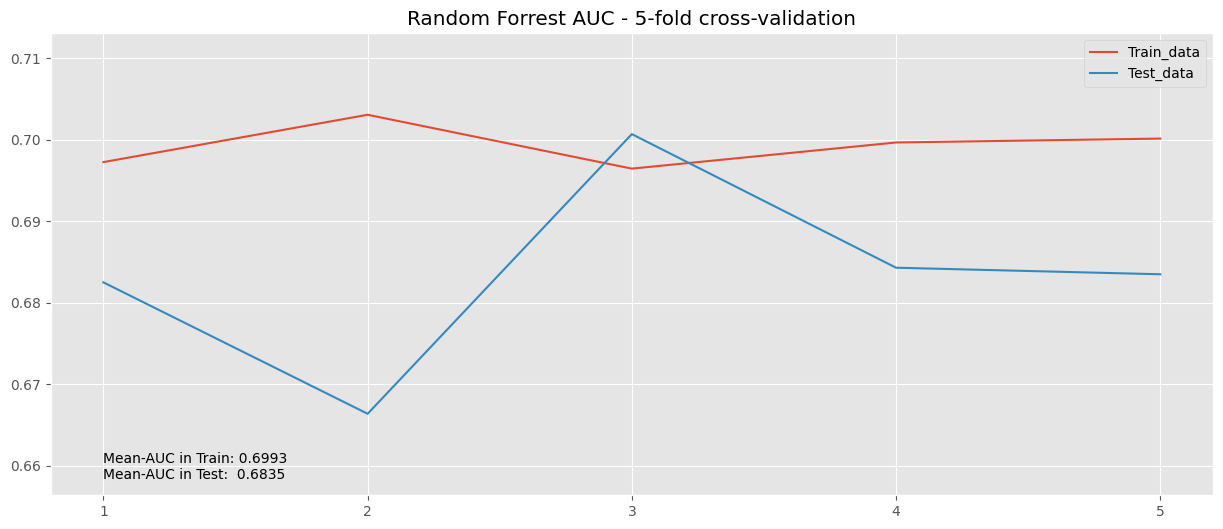

In [18]:
cv_results_rf_final = cross_validate(
    best_clf_rf, X_train, y_train, cv=5,
    scoring=("roc_auc", "accuracy"),
    return_train_score=True
)

train_lr, test_lr = cv_results_rf_final["train_roc_auc"], cv_results_rf_final["test_roc_auc"]

values_aucs_lr = np.concatenate((train_lr, test_lr), axis=None)
min_y, max_y = values_aucs_lr.min() -0.01 , values_aucs_lr.max()+ 0.01
means_rf = (train_lr.mean(), test_lr.mean())
##
plt.plot(cv_results_rf_final["train_roc_auc"], label="Train_data")
plt.plot(cv_results_rf_final["test_roc_auc"], label="Test_data")
plt.title("Random Forrest AUC - 5-fold cross-validation")
plt.legend()
plt.text(0, min_y + 4e-03, f"Mean-AUC in Train: {means_rf[0]:.4f}")
plt.text(0, min_y + 2e-03, f"Mean-AUC in Test:  {means_rf[1]:.4f}")
plt.ylim(min_y, max_y)
plt.xticks(np.arange(0,5), np.arange(1,6))
plt.show()